In [139]:
from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
from cameo import phenotypic_phase_plane
plotter = PlotlyPlotter()

## Brief summary

Here different substrates are tested first on LB rich media and later on M9 minimal media.

We assess the ratio of production between violacein and deoxyviolacein as explained in the report. Depending on whether we are working with rich media or minimal media the ratios change. For LB media deoxyviolacein production is 1.9 times higher than violacein production. For M9 media deoxyviolacein production is 4.2 times lower than violacein production.

The default boundaries are set to -10 for uptake rates, so we change it to -21.5, the value calculated for glucose uptake experimentally [Long et al. 2017]. Since no information about other substrates is found, we use the same boundary for all the studied substrates. The medium includes oxygen, necessary for violacein production, which we set to -1000, being the substrate the limiting factor.

The results obtained match the studied substrate uptake rates by [Hoffart et al. 2017]. *V. natriegens* was found to have the highest growth rate when growing on sucrose (3.14 h-1 on LB, 0.89 h-1 on M9). We obtained the following results for glucose (2.84 h-1 on LB, 0.72 h-1 on M9) and N-acetylglucosamine (2.68 h-1 on LB, 0.62 h-1 on M9), D-mannitol (2.84 h-1 on LB, 0.72 h-1 on M9) and glycerol (2.67 h-1 on LB, 0.54 h-1 on M9). The results are not completely accurate but give an idea on how they could benefit violacein production.

# Model with media LB with added violacein

In [148]:
model_LB_vio_fad=read_sbml_model('Models/model_VN_LB_vio-fad.xml')

Added ratio constraint in LB media between violacein and deoxyviolacein.

In [150]:
ratio = model_LB_vio_fad.problem.Constraint(
    1.9*model_LB_vio_fad.reactions.Violacein.flux_expression - 1*model_LB_vio_fad.reactions.Deoxyviolacein.flux_expression,
    lb=0, ub=0)
model_LB_vio_fad.add_cons_vars(ratio)

## Glucose as substrate

Maximize
1.0*Violacein - 1.0*Violacein_reverse_b748d
Objective
1.0 Violacein = 6.403573272041996

Uptake
------
Metabolite    Reaction  Flux  C-Number C-Flux
     adn_e    EX_adn_e 3.806        10  3.98%
  arg__L_e EX_arg__L_e    10         6  6.27%
  asp__L_e EX_asp__L_e    10         4  4.18%
     cmp_e    EX_cmp_e    10         9  9.40%
    dcyt_e   EX_dcyt_e    10         9  9.40%
  glc__D_e EX_glc__D_e  21.5         6 13.48%
  glu__L_e EX_glu__L_e    10         5  5.22%
     gly_e    EX_gly_e    10         2  2.09%
     h2o_e    EX_h2o_e    10         0  0.00%
       h_e      EX_h_e    10         0  0.00%
      o2_e     EX_o2_e    50         0  0.00%
  pro__L_e EX_pro__L_e    10         5  5.22%
   thymd_e  EX_thymd_e    10        10 10.45%
  trp__L_e EX_trp__L_e    10        11 11.49%
     ump_e    EX_ump_e    10         9  9.40%
     uri_e    EX_uri_e    10         9  9.40%

Secretion
---------
Metabolite    Reaction   Flux  C-Number C-Flux
      dv_c     DM_dv_c -12.17        2

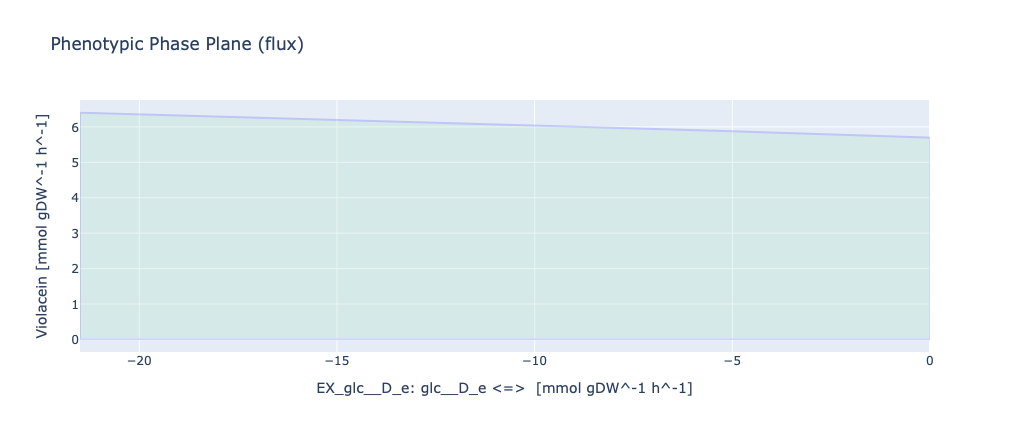

Setting Glucose boundary to -21.5:
- The optimal Glucose uptake for Violacein flux is [h^-1]: -21.5
- Growth rate for V. natriegens [h^-1]: 5.544671643893936
- Max. violacein production [mmol gDW^-1 h^-1]: 6.403573272041995
- Theoretical maximum yield [mmol_vio / mmol_glc]: 0.29784061730427885


In [160]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    print(model_LB_vio_fad.objective) # DEFAULT OBJECTIVE, SHOULD IT BE VIOLACEIN ALL THE TIME? OR GROWTH?
    
    # Setting the medium and boundary conditions
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -50
    model_LB_vio_fad.reactions.EX_glc__D_e.lower_bound = -21.5
    
    # Seing what is being consumed in the media
    print(model_LB_vio_fad.summary())
    
    # Setting the objective to growth
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    print(model_LB_vio_fad.optimize().fluxes['Growth'])
    
    # Computing maximum yield
    violacein_glc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glc__D_e.flux)
    
    
    # Phenotypic phane plane of glucose-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glc__D_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    print(result.data_frame)
    result.plot(plotter)
    #### WHY PLOTS CHANGE DEPENDING ON WHAT IS THE OBJECTIVE SAVED IN THE MODEL (BEFORE ANY MODIFICATION)
    # IN GLUCOSE OBJECTIVE IS GROWTH, ON MANNITOL IS VIOLACEIN (WEIRD)
    
    # Computing the glucose uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_glc__D_e[round(data.objective_upper_bound,4) == maxvio]
    
    
    print('Setting Glucose boundary to -21.5:')
    print("- The optimal Glucose uptake for Violacein flux is [h^-1]:", max(v))
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate) # HOW THE GROWTH SHOULD BE TAKEN IF OBJECTIVE IS VIOLACEIN?
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)

## D-mannitol as substrate

Objective
1.0 Violacein = 1.470588235294118

Uptake
------
Metabolite    Reaction   Flux  C-Number C-Flux
  arg__L_e EX_arg__L_e  1.091         6  6.31%
       h_e      EX_h_e   1.85         0  0.00%
      o2_e     EX_o2_e     10         0  0.00%
   thymd_e  EX_thymd_e 0.3309        10  3.19%
  trp__L_e EX_trp__L_e  8.529        11 90.50%

Secretion
---------
Metabolite  Reaction    Flux  C-Number C-Flux
      dv_c   DM_dv_c  -2.794        20 53.90%
       v_c    DM_v_c  -1.471        20 28.37%
     co2_e  EX_co2_e   -9.62         1  9.28%
    etoh_e EX_etoh_e -0.6618         2  1.28%
     for_e  EX_for_e -0.3309         1  0.32%
     h2o_e  EX_h2o_e  -7.488         0  0.00%
     nh4_e  EX_nh4_e  -6.446         0  0.00%
     orn_e  EX_orn_e  -1.091         5  5.26%
    thym_e EX_thym_e -0.3309         5  1.60%



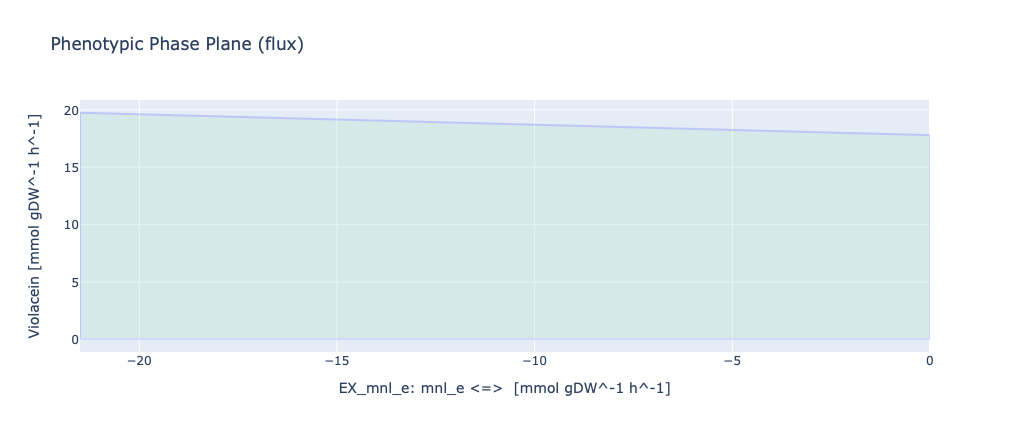

Setting D-mannitol boundary to -21.5:
- The optimal D-mannitol uptake for Violacein flux is [h^-1]: -21.5
- Growth rate for V. natriegens [h^-1]: 21.74075511769916
- Max. violacein production [mmol gDW^-1 h^-1]: 19.759856781213717
- Theoretical maximum yield [mmol_vio / mmol_mnl]: 0.9190631061029636


In [163]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value

    # Setting the medium and boundary conditions
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 10
    model_LB_vio_fad.medium = medium
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_LB_vio_fad.reactions.EX_mnl_e.lower_bound = -21.5
    
    # Seing what is being consumed in the media
    print(model_LB_vio_fad.summary())
    
    # Setting the objective to violacein
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    # Setting the objective to growth
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    
    # Computing maximum yield
    violacein_mnl_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_mnl_e.flux)
    
    # Phenotypic phane plane of mannitol-violacein
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_mnl_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    # Computing the D-mannitol uptake rate for the maximum violacein production
    data = result.data_frame
    maxvio = round(data.objective_upper_bound[data.objective_upper_bound.idxmax()], 4)
    v = data.EX_mnl_e[round(data.objective_upper_bound,4) == maxvio]
    
    print('Setting D-mannitol boundary to -21.5:')
    print("- The optimal D-mannitol uptake for Violacein flux is [h^-1]:", max(v))
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_mnl]:', violacein_mnl_yield)

## Sucrose as substrate

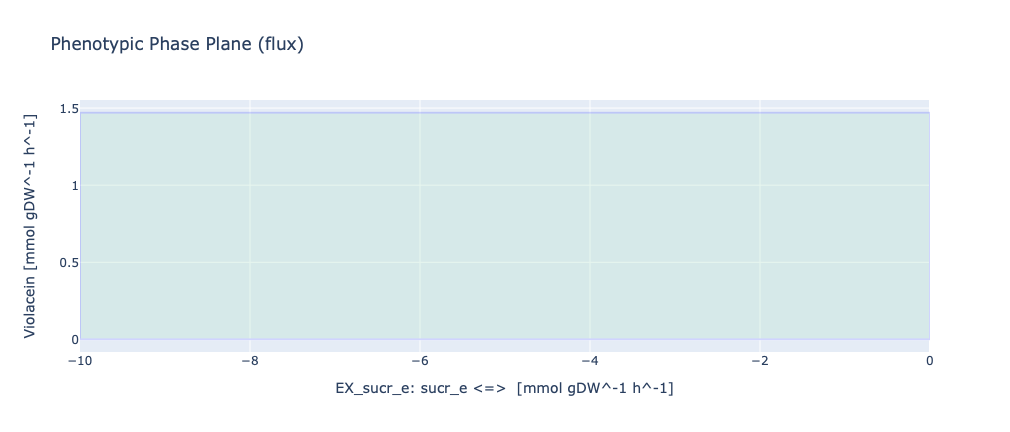

Oxygen and Sucrose boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 3.14203990553626
- Max. violacein production [mmol gDW^-1 h^-1]: 1.4705882352941073
- Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.14705882352941074


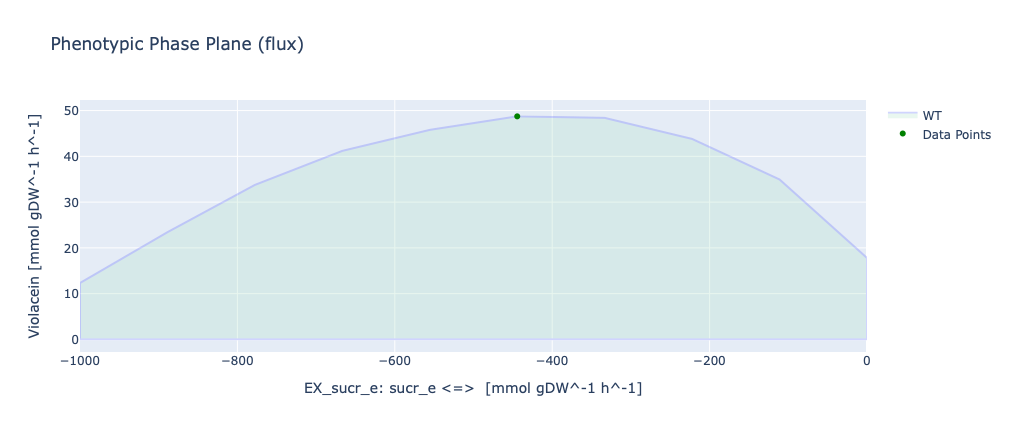

Setting Oxygen and Sucrose boundaries to -1000:
- The optimal Sucrose uptake for Violacein flux is [h^-1]: -444.44444444444446
- Growth rate for V. natriegens [h^-1]: 38.691495129932335
- Max. violacein production [mmol gDW^-1 h^-1]: 49.035409195794855
- Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.14705882352941074


In [6]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 10
    model_LB_vio_fad.medium = medium
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value

    violacein_sucr_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_sucr_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_sucr_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and Sucrose boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)
    
    
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_LB_vio_fad.reactions.EX_sucr_e.lower_bound = -1000
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    
    violacein_mnl_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_sucr_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_sucr_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting Oxygen and Sucrose boundaries to -1000:')
    print("- The optimal Sucrose uptake for Violacein flux is [h^-1]:", result.data_frame.EX_sucr_e[result.data_frame.objective_upper_bound.idxmax()])
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)

## Glycerol as substrate

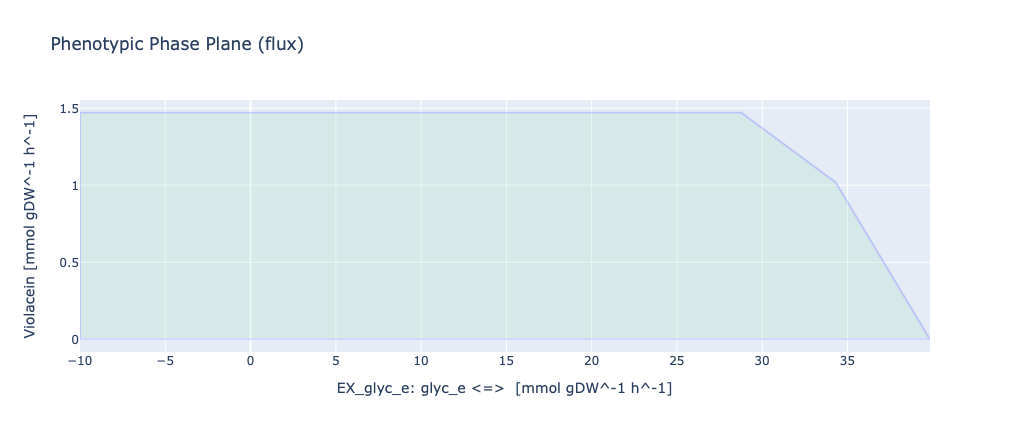

Oxygen and Glycerol boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 2.6688478035262118
- Max. violacein production [mmol gDW^-1 h^-1]: 1.4705882352947852
- Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.14705882352947852


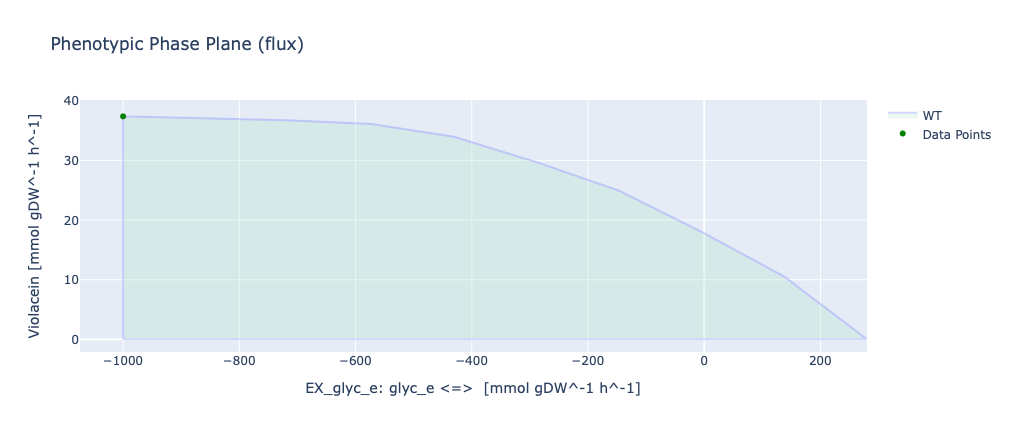

Setting Oxygen and Glycerol boundaries to -1000:
- The optimal Glycerol uptake for Violacein flux is [h^-1]: -1000.0
- Growth rate for V. natriegens [h^-1]: 38.683485483381844
- Max. violacein production [mmol gDW^-1 h^-1]: 37.38757328616814
- Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.03738757328616814


In [7]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 10
    model_LB_vio_fad.medium = medium
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value

    violacein_glyc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glyc_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glyc_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and Glycerol boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)
    
    
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_LB_vio_fad.reactions.EX_glyc_e.lower_bound = -1000
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    
    violacein_glyc_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_glyc_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_glyc_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting Oxygen and Glycerol boundaries to -1000:')
    print("- The optimal Glycerol uptake for Violacein flux is [h^-1]:", result.data_frame.EX_glyc_e[result.data_frame.objective_upper_bound.idxmax()])
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)

## N-acetyl-D-glucosamine as substrate

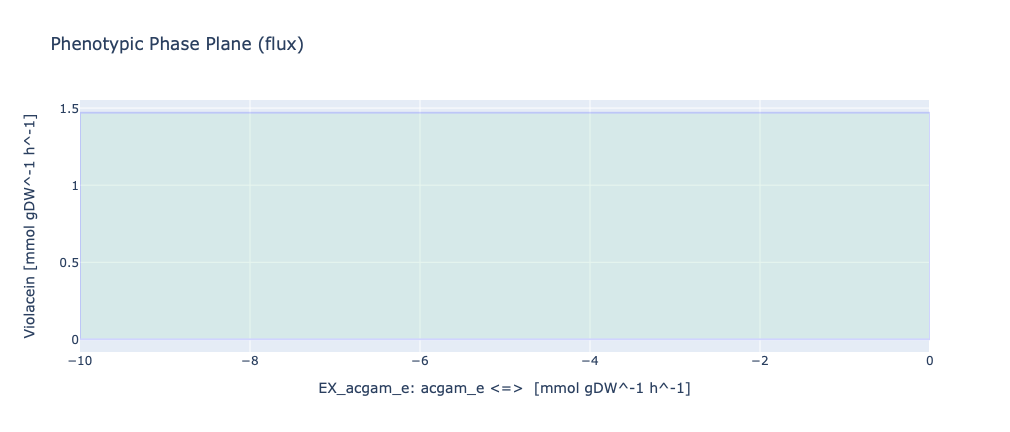

Oxygen and N-acetyl-D-glucosamine boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 2.6769806205561792
- Max. violacein production [mmol gDW^-1 h^-1]: 1.4705882352941229
- Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.1470588235294123


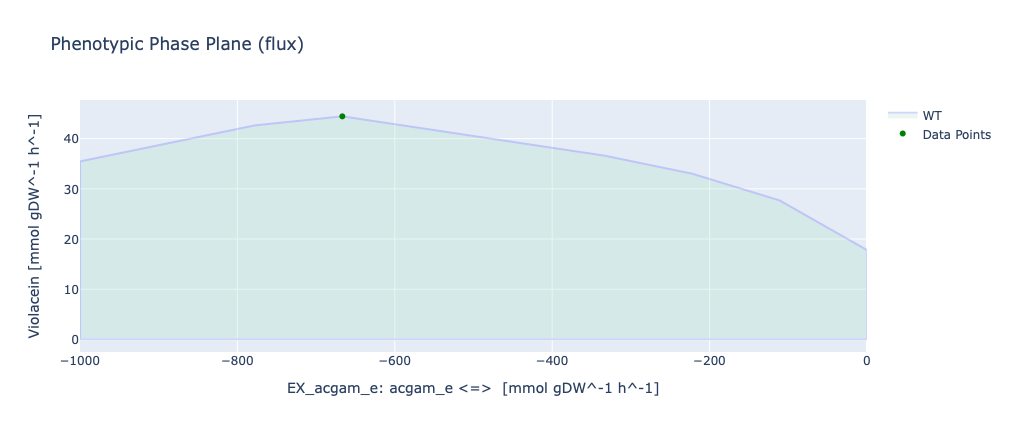

Setting Oxygen and N-acetyl-D-glucosamine boundaries to -1000:
- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [h^-1]: -666.6666666666666
- Growth rate for V. natriegens [h^-1]: 31.595728343094873
- Max. violacein production [mmol gDW^-1 h^-1]: 45.00907441016334
- Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.09141608890605447


In [8]:
medium = model_LB_vio_fad.medium

with model_LB_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 10
    model_LB_vio_fad.medium = medium
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value

    violacein_acgam_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_acgam_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_acgam_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and N-acetyl-D-glucosamine boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)
    
    
    model_LB_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_LB_vio_fad.reactions.EX_acgam_e.lower_bound = -1000
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Violacein
    violacein_production = model_LB_vio_fad.optimize().objective_value
    
    model_LB_vio_fad.objective = model_LB_vio_fad.reactions.Growth
    growth_rate = model_LB_vio_fad.optimize().objective_value
    
    violacein_acgam_yield = violacein_production / (-1*model_LB_vio_fad.reactions.EX_acgam_e.flux)
    
    result = phenotypic_phase_plane(model_LB_vio_fad, 
                                variables=[model_LB_vio_fad.reactions.EX_acgam_e],
                                objective=model_LB_vio_fad.reactions.Violacein,
                                points=10)
    x = result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()]
    y = result.data_frame.objective_upper_bound[result.data_frame.objective_upper_bound.idxmax()]
    result.plot(plotter, points=[(x,y)], points_colors=["green"])
    
    print('Setting Oxygen and N-acetyl-D-glucosamine boundaries to -1000:')
    print("- The optimal N-acetyl-D-glucosamine uptake for Violacein flux is [h^-1]:", result.data_frame.EX_acgam_e[result.data_frame.objective_upper_bound.idxmax()])
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)

# Model with media M9 with added violacein

In [9]:
model_M9_vio_fad=read_sbml_model('Models/model_VN_M9_vio-fad.xml')

Added ratio constraint in M9 media between Violacein and Deoxyviolacein.

In [10]:
ratio = model_M9_vio_fad.problem.Constraint(
    model_M9_vio_fad.reactions.Violacein.flux_expression - 4.2*model_M9_vio_fad.reactions.Deoxyviolacein.flux_expression,
    lb=0, ub=0)
model_M9_vio_fad.add_cons_vars(ratio)

## Glucose as substrate

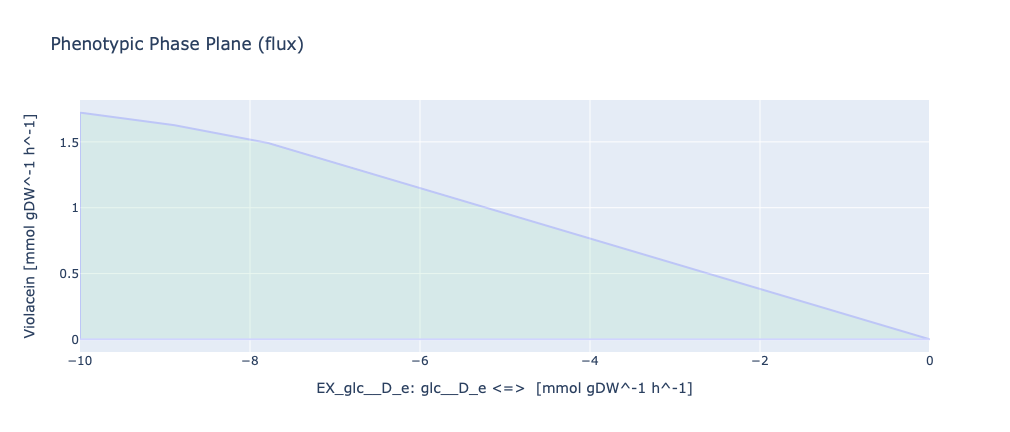

Oxygen and Glucose boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 0.7188575696969707
- Max. violacein production [mmol gDW^-1 h^-1]: 1.7223198594024605
- Theoretical maximum yield [mmol_vio / mmol_glc]: 0.17223198594024605


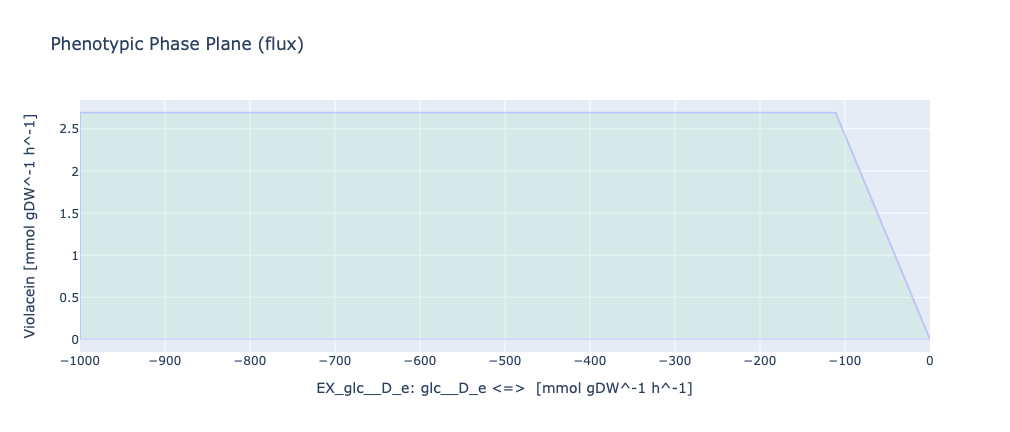

Setting Oxygen and Glucose boundaries to -1000:
- Growth rate for V. natriegens [h^-1]: 0.8930785785011155
- Max. violacein production [mmol gDW^-1 h^-1]: 2.692307692307673
- Theoretical maximum yield [mmol_vio / mmol_glc]: 0.21764856803345742


In [11]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    model_M9_vio_fad.medium = medium
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_glc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glc__D_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glc__D_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and Glucose boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)
    
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_M9_vio_fad.reactions.EX_glc__D_e.lower_bound = -1000
    
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    #model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    #growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_glc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glc__D_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glc__D_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Setting Oxygen and Glucose boundaries to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glc]:', violacein_glc_yield)

## D-mannitol as substrate

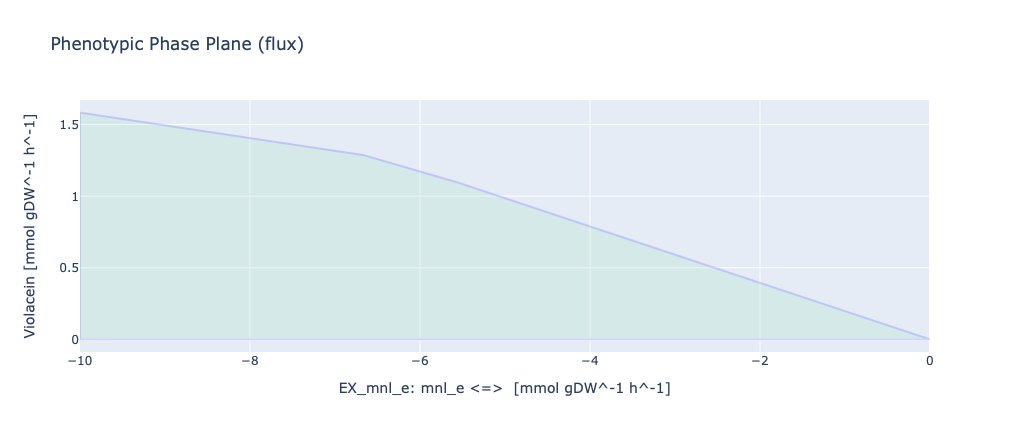

Oxygen and D-mannitol boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 0.7188575696969657
- Max. violacein production [mmol gDW^-1 h^-1]: 1.582666038624587
- Theoretical maximum yield [mmol_vio / mmol_mnl]: 0.1582666038624587


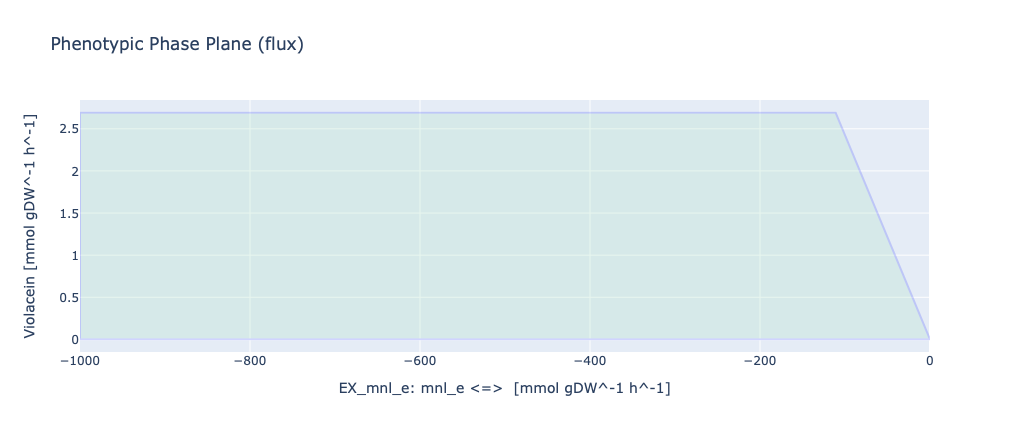

Setting Oxygen and D-mannitol boundaries to -1000:
- Growth rate for V. natriegens [h^-1]: 0.8930785785011327
- Max. violacein production [mmol gDW^-1 h^-1]: 2.6923076923079297
- Theoretical maximum yield [mmol_vio / mmol_mnl]: 0.2455092508233545


In [12]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_mnl_e'] = 10
    model_M9_vio_fad.medium = medium
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_mnl_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_mnl_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_mnl_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and D-mannitol boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_mnl]:', violacein_mnl_yield)
    
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_M9_vio_fad.reactions.EX_mnl_e.lower_bound = -1000
    
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_mnl_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_mnl_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_mnl_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Setting Oxygen and D-mannitol boundaries to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_mnl]:', violacein_mnl_yield)

## Sucrose as substrate

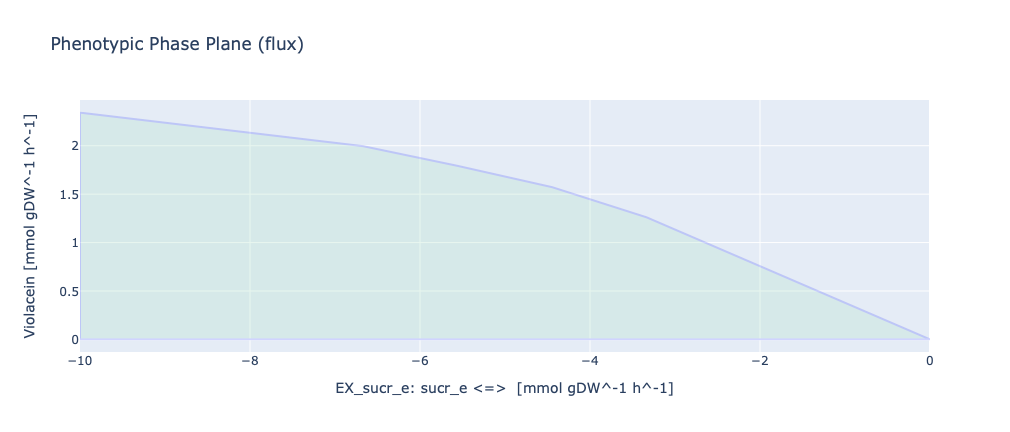

Oxygen and Sucrose boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 0.893078578501124
- Max. violacein production [mmol gDW^-1 h^-1]: 2.34200743494459
- Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.234200743494459


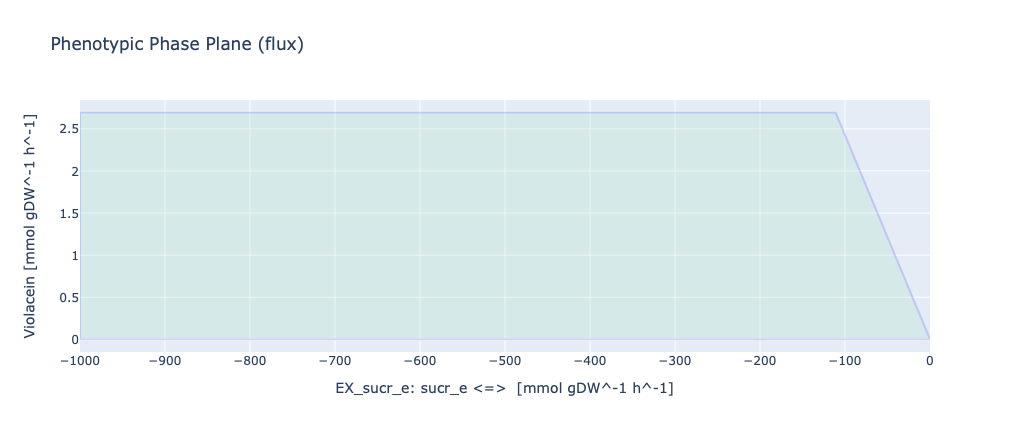

Setting Oxygen and Sucrose boundaries to -1000:
- Growth rate for V. natriegens [h^-1]: 0.8930785785011142
- Max. violacein production [mmol gDW^-1 h^-1]: 2.6923076923076996
- Theoretical maximum yield [mmol_vio / mmol_sucr]: 0.234200743494459


In [13]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_sucr_e'] = 10
    model_M9_vio_fad.medium = medium
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value

    violacein_sucr_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_sucr_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_sucr_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and Sucrose boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)
    
    
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_M9_vio_fad.reactions.EX_sucr_e.lower_bound = -1000
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_mnl_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_sucr_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_sucr_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Setting Oxygen and Sucrose boundaries to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_sucr]:', violacein_sucr_yield)

## Glycerol as substrate

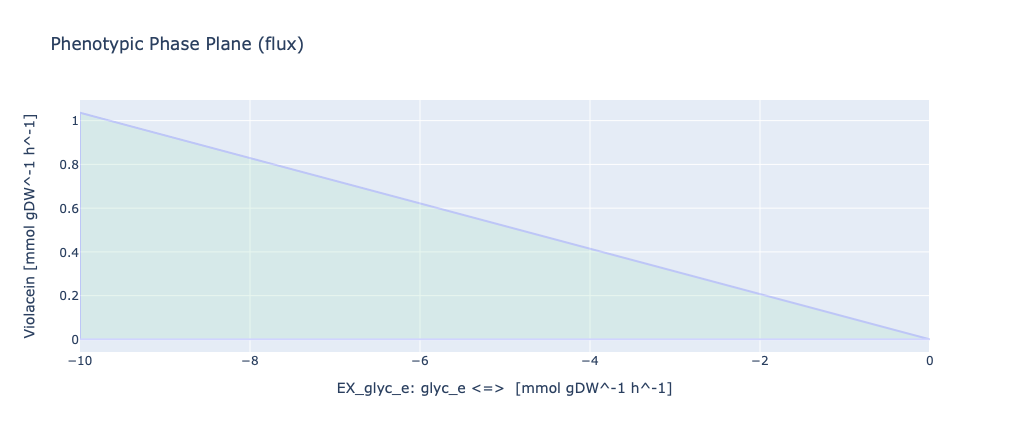

Oxygen and Glycerol boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 0.5364811289203397
- Max. violacein production [mmol gDW^-1 h^-1]: 1.0367226745193137
- Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.10367226745193137


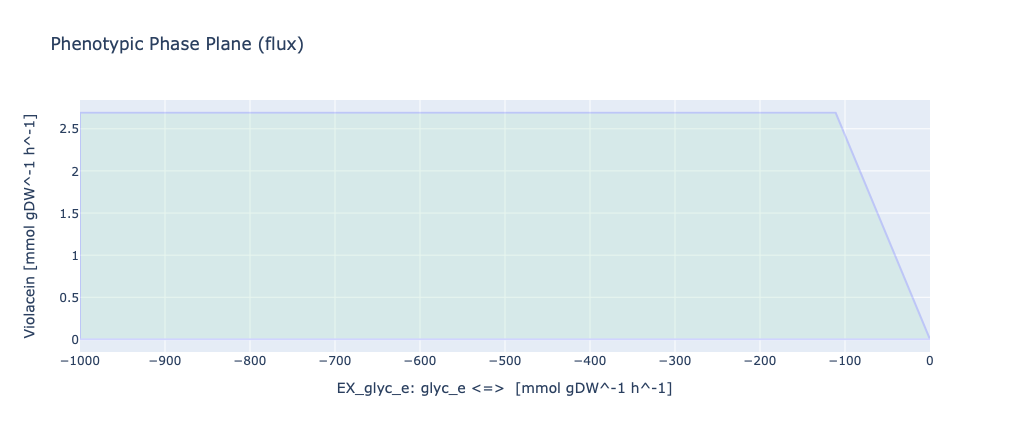

Setting Oxygen and Glycerol boundaries to -1000:
- Growth rate for V. natriegens [h^-1]: 0.8930785785011153
- Max. violacein production [mmol gDW^-1 h^-1]: 2.6923076923077534
- Theoretical maximum yield [mmol_vio / mmol_glyc]: 0.1367040627365497


In [14]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_glyc_e'] = 10
    model_M9_vio_fad.medium = medium
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value

    violacein_glyc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glyc_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glyc_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and Glycerol boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)
    
    
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_M9_vio_fad.reactions.EX_glyc_e.lower_bound = -1000
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_glyc_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_glyc_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_glyc_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Setting Oxygen and Glycerol boundaries to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_glyc]:', violacein_glyc_yield)

## N-acetyl-D-glucosamine as substrate

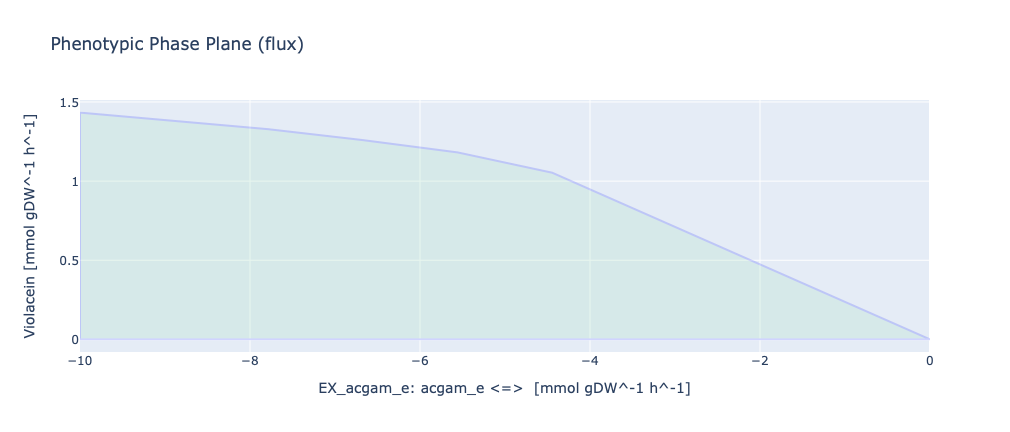

Oxygen and N-acetyl-D-glucosamine boundaries set to default values (-10):
- Growth rate for V. natriegens [h^-1]: 0.6167879625967826
- Max. violacein production [mmol gDW^-1 h^-1]: 1.4328602620087334
- Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.14328602620087333


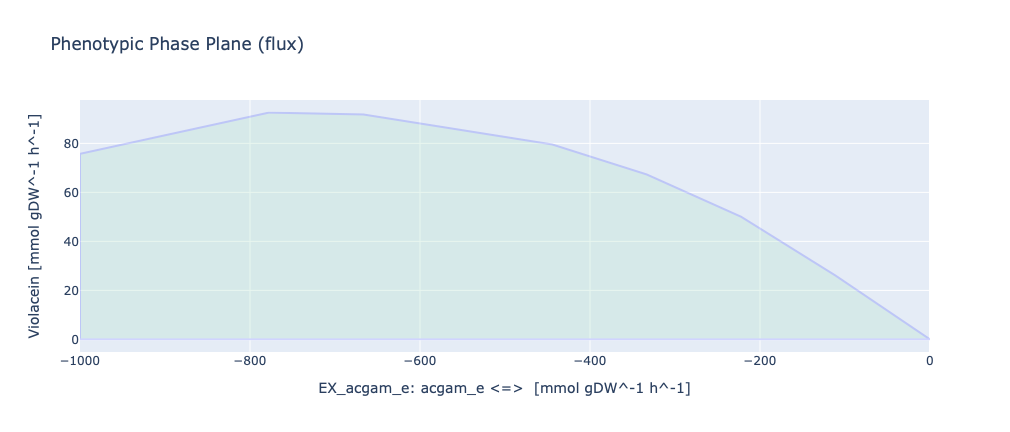

Setting Oxygen and N-acetyl-D-glucosamine boundaries to -1000:
- Growth rate for V. natriegens [h^-1]: 10.141031322599313
- Max. violacein production [mmol gDW^-1 h^-1]: 95.64777327935244
- Theoretical maximum yield [mmol_vio / mmol_acgam]: 0.1433165773067485


In [15]:
medium = model_M9_vio_fad.medium

with model_M9_vio_fad:
    
    medium['EX_glc__D_e'] = 0
    medium['EX_acgam_e'] = 10
    model_M9_vio_fad.medium = medium
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value

    violacein_acgam_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_acgam_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_acgam_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Oxygen and N-acetyl-D-glucosamine boundaries set to default values (-10):')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)
    
    
    model_M9_vio_fad.reactions.EX_o2_e.lower_bound = -1000
    model_M9_vio_fad.reactions.EX_acgam_e.lower_bound = -1000
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Violacein
    violacein_production = model_M9_vio_fad.optimize().objective_value
    
    model_M9_vio_fad.objective = model_M9_vio_fad.reactions.Growth
    growth_rate = model_M9_vio_fad.optimize().objective_value
    
    violacein_acgam_yield = violacein_production / (-1*model_M9_vio_fad.reactions.EX_acgam_e.flux)
    
    result = phenotypic_phase_plane(model_M9_vio_fad, 
                                variables=[model_M9_vio_fad.reactions.EX_acgam_e],
                                objective=model_M9_vio_fad.reactions.Violacein,
                                points=10)
    result.plot(plotter)
    
    print('Setting Oxygen and N-acetyl-D-glucosamine boundaries to -1000:')
    print('- Growth rate for V. natriegens [h^-1]:', growth_rate)
    print('- Max. violacein production [mmol gDW^-1 h^-1]:', violacein_production)
    print('- Theoretical maximum yield [mmol_vio / mmol_acgam]:', violacein_acgam_yield)